# Routines to compare PYPIT with LowRedux (v0.1)

In [22]:
%matplotlib inline

In [1]:
# imports
from linetools.spectra import io as lsio
from linetools.spectra.xspectrum1d import XSpectrum1D
# 
import matplotlib as mpl
mpl.rcParams['font.family'] = 'stixgeneral'
mpl.rc('xtick', labelsize=20) 
mpl.rc('ytick', labelsize=20) 
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

## Filenames

### LowRedux

In [2]:
scifile = '/Users/xavier/PYPIT/Kast_red/Science/sci-r153.fits.gz'
lwrdx_wavefile = '/Users/xavier/PYPIT/Kast_red/wave-r124.fits'

### PYPIT

In [11]:
pypit_boxfile = '/Users/xavier/PYPIT/TEST_SUITES/Kast_red/MasterFrames/J0025-0312_000_boxcar.fits'
pypit_skyfile = '/Users/xavier/PYPIT/TEST_SUITES/Kast_red/MasterFrames/J0025-0312_000_sky.fits'
pypit_objtrcfile = '/Users/xavier/PYPIT/TEST_SUITES/Kast_red/MasterFrames/J0025-0312_000_objtrc.fits'
pypit_wavefile= '/Users/xavier/PYPIT/TEST_SUITES/Kast_red/MasterFrames/mswvimg_red_000.fits'

## Init

In [ ]:
lrdx_scihdu = fits.open(scifile)

## Traces

### Read

In [17]:
# Read PYPIT
pypit_objtrc = fits.open(pypit_objtrcfile)[0].data
if pypit_objtrc.shape[1] > 1:
    raise ValueError('Not ready for multiple objects')
# Read LowRedux
lwrdx_objtrc = sciobj['XPOS']

In [20]:
print(pypit_objtrc.shape, lwrdx_objtrc.shape)

((1199, 1), (1200,))


### Plot

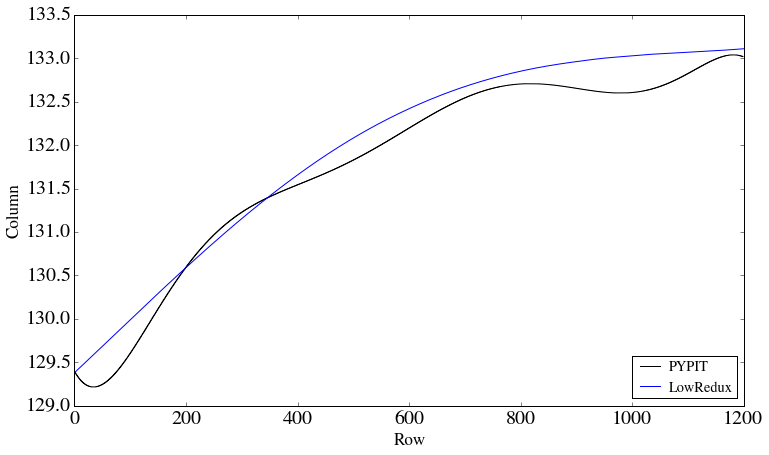

In [26]:
plt.clf()
plt.figure(figsize=(12,7))
ax = plt.gca()
# PYPIT
ax.plot(pypit_objtrc[:,0], 'k-', drawstyle='steps', label='PYPIT')
# LowRedux
ax.plot(lwrdx_objtrc, '-', color='blue', label='LowRedux')
# Axes
#ax.set_ylim(0.,np.median(pys2n)*2.)
ax.set_xlabel('Row',fontsize=17.)
ax.set_ylabel('Column',fontsize=17.)
# Legend
legend = plt.legend(loc='lower right', borderpad=0.3,
            handletextpad=0.3, fontsize='x-large')
# Finish
plt.show()
plt.close()
#

## Sky Models

In [5]:
# Load sky and wavelength images
pypit_wave = fits.open(pypit_wavefile)[0].data
pypit_sky = fits.open(pypit_skyfile)[0].data
#
lwrdx_wave = fits.open(lwrdx_wavefile)[0].data
lwrdx_sky = lrdx_scihdu[2].data

In [6]:
print(pypit_wave.shape, pypit_sky.shape)

((1199, 250), (1199, 250))


## Compare Boxcar Spectra

In [8]:
# Read/Load
pypit_boxspec = lsio.readspec(pypit_boxfile)
# Read LowRedux
sciobj = Table(lrdx_scihdu[5].data)[0] # Might have to deal with more than one obj
sig = np.sqrt(sciobj['MASK_BOX']/(sciobj['SIVAR_BOX'] + (sciobj['MASK_BOX']==0)))
lwrdx_boxspec = XSpectrum1D.from_tuple( (sciobj['WAVE_BOX'], sciobj['FLUX_BOX'], sig) )

### Quick plot of the spectra

In [9]:
plt.clf()
plt.figure(figsize=(12,7))
ax = plt.gca()
ymax = np.median(pypit_boxspec.flux)*2.
# PYPIT
ax.plot(pypit_boxspec.dispersion, pypit_boxspec.flux, 'k-', drawstyle='steps')
ax.plot(pypit_boxspec.dispersion, pypit_boxspec.sig, 'g-', drawstyle='steps')
# LowRedux
ax.plot(lwrdx_boxspec.dispersion, lwrdx_boxspec.flux, '-', color='blue')
ax.plot(lwrdx_boxspec.dispersion, lwrdx_boxspec.sig, '-', color='gray')
# Axes
ax.set_ylim(0.,ymax)
ax.set_xlabel('Wavelength',fontsize=17.)
# Finish
plt.show()
plt.close()
#

### S/N

In [ ]:
plt.clf()
plt.figure(figsize=(12,7))
ax = plt.gca()
ymax = np.median(pypit_boxspec.flux)*2.
# PYPIT
gdpy = pypit_boxspec.sig > 0.
pys2n =  pypit_boxspec.flux[gdpy]/pypit_boxspec.sig[gdpy]
ax.plot(pypit_boxspec.dispersion[gdpy],pys2n, 'k-', drawstyle='steps')
# LowRedux
gdlx = lwrdx_boxspec.sig > 0.
ax.plot(lwrdx_boxspec.dispersion[gdlx], lwrdx_boxspec.flux[gdlx]/lwrdx_boxspec.sig[gdlx], '-', color='blue')
# Axes
ax.set_ylim(0.,np.median(pys2n)*2.)
ax.set_xlabel('Wavelength',fontsize=17.)
ax.set_ylabel('S/N per pixel',fontsize=17.)
# Finish
plt.show()
plt.close()
#

In [10]:
sciobj

OBJID,SLITID,XFRACPOS,PEAKFLUX,MASKWIDTH,FWHM,FLX_SHFT_WAV,FLX_SHFT_SPA,FWHMFIT [1200],XPOS [1200],YPOS [1200],HAND_AP,HAND_X,HAND_Y,HAND_MINX,HAND_MAXX,HAND_FWHM,HAND_SUB,WAVE_OPT [1200],FLUX_OPT [1200],SIVAR_OPT [1200],IVAR_OPT [1200],SKY_OPT [1200],RN_OPT [1200],NIVAR_OPT [1200],MASK_OPT [1200],FRAC_USE [1200],CHI2 [1200],WAVE_BOX [1200],FLUX_BOX [1200],SIVAR_BOX [1200],IVAR_BOX [1200],NIVAR_BOX [1200],SKY_BOX [1200],RN_BOX [1200],MASK_BOX [1200],MINCOL,MAXCOL,BOX_RAD,ARC_FWHM_FIT [1200],ARC_FWHM_MED,PIX_RES,BINNING [2]
int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,int32,float64,float32,float32,float32,float32,float32,float32,uint8,float32,float32,float64,float32,float32,float32,float32,float32,float32,uint8,int32,int32,int16,float32,float64,float64,int32
1,1,0.470201,112.505,15.48,3.48127,0.12,0.0,3.59091 .. 3.65211,129.38 .. 133.111,0.0 .. 1199.0,0,0.0,0.0,0.0,0.0,0.0,0,5370.24173801 .. 8175.58889084,0.0 .. 359.202,0.0 .. 0.000510373,0.0 .. 0.000510373,0.0 .. 671.115,0.0 .. 14.6393,0.0 .. 0.000508439,0 .. 1,0.0 .. 0.999995,0.0 .. 3.85025,5370.24145247 .. 8175.58845694,-0.0 .. 406.755,0.0 .. 0.000240908,0.0 .. 0.000240908,0.0 .. 0.000240908,2252.3 .. 1577.65,22.4499 .. 22.4499,0 .. 1,103,159,7,1.41926 .. 1.26241,1.52592325211,nan,0 .. 0


In [ ]:
lwrdx_boxspec.sig

In [ ]:
xdb.xpcol(lwrdx_boxspec.sig, pypit_boxspec.sig)